# Tutorlal for extracting SEDs from Galacticus output.

Note that to extract an SED Galacticus must have been run with the option to output an array of top hat filters at user-specified wavelengths.

In [1]:
import sys
import numpy as np
from galacticus.plotting.utils import *
from galacticus.io import GalacticusHDF5
from galacticus.spectralEnergyDistributions import GalacticusSED
%matplotlib inline

In [2]:
# Load Galacticus HDF5 file and initialize GalacticusHDF5 class to load Galacticus data
#ifile = "/Users/amerson/Data/Galacticus_Out/v0.9.4/wfirstSED_singleTree_lightcone/galacticus.hdf5"
ifile = "../galacticus/data/exampleRuns/galacticus.snapshotExample.hdf5"
GH5 = GalacticusHDF5(ifile,'r')

In [3]:
# Print redshift outputs                                                                                                                                                        
print("Redshift Outputs:")
for i,z in enumerate(GH5.outputs):
    print(GH5.outputs.name[i]+": z = "+str(GH5.outputs.z[i]))

Redshift Outputs:
Output1: z = 2.0
Output2: z = 1.0
Output3: z = 0.0


In [4]:
# Initialize class to compute and extract Galacticus SEDs. Pass Galacticus HDF5 object to GalacticusSED class.
GalSED = GalacticusSED(GH5,verbose=True)

In [40]:
# EXAMPLE 1: Extract example SED at snapshot nearest to z = 1.4 with S/N=5 and using galaxy velocity dispersions to 
#            approximate the widths of Gaussian emission line profiles. Assume observer-frame.
# First step is to build the SED dataset name
z = 1.4
zStr = GH5.getRedshiftString(z)
print("We can see that the nearest HDF5 output has redshift string '"+zStr+"'")
name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
print(name)

We can see that the nearest HDF5 output has redshift string 'z1.0000'
totalSED:observed:Gaussian_VelocityApprox:snr5.0:z1.0000


The dataset names for the SEDs have the following nomenclature:

    <component>SED:<frame>(:<lineProfile>_<lineWidthMethod>)(:snr<SNR>):z<redshift>(:recent)(:dust<dustOptions>)
    
where:

    <component> = The component of the galaxy (disk, spheroid, or total). [Default = total]
    <frame> = The frame of the SED ('rest' or 'observed').
    <lineProfile> = If emission lines are requested, the profile to use for emission lines. [Options: Gaussian]
    <lineWidth> = If emission lines are requested, the method to compute the line width. This is either:
                'VelocityApprox', where the width is estimated from an estimate of the rotational velocity (or
                velocity dispersion) of the galaxy; of 'fixedWidth<X>', where the lines are all assigned a fixed
                width of X km/s.
    <SNR> = If provided, the continuum will be perturbed using the specified S/N ratio.
    <redshift> = The redshift of the snapshot output in which this galaxy is found (e.g 1.4000). Note that for
                lightcones this may be different to the redshift of the galaxy in the lightcone.
    <dustOptions> = If the SED has attenuated by interstellar this will consist of a string of commands 
                    describing the dust method that has been applied.
                    
If :recent is present, the luminosity will correspond to star formation that has occured in the last X Gyrs.

In [42]:
# Print wavelengths, in Angstroms, for which we have top hat filters
print(GalSED.getAvailableWavelengths(name))

[  2000.   3000.   4000.   5000.   6000.   7000.   8000.   9000.  10000.
  11500.  13500.  15500.  17500.  19500.]


In [58]:
# Set wavelength range to obtain SED over
wavelengths = np.linspace(2000,19000,500)

In [59]:
# Build SED (use linear interpolation to get SED at specified wavelengths)
SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')

In [60]:
# Get SEDs for galaxies
print SED.wavelength.shape,SED.sed.shape
print("Number of galaxies = "+str(SED.sed.shape[0]))
print SED.wavelength
print SED.sed[:,5]

(500,) (160, 500)
Number of galaxies = 160
[  2000.           2034.06813627   2068.13627255   2102.20440882
   2136.27254509   2170.34068136   2204.40881764   2238.47695391
   2272.54509018   2306.61322645   2340.68136273   2374.749499
   2408.81763527   2442.88577154   2476.95390782   2511.02204409
   2545.09018036   2579.15831663   2613.22645291   2647.29458918
   2681.36272545   2715.43086172   2749.498998     2783.56713427
   2817.63527054   2851.70340681   2885.77154309   2919.83967936
   2953.90781563   2987.9759519    3022.04408818   3056.11222445
   3090.18036072   3124.24849699   3158.31663327   3192.38476954
   3226.45290581   3260.52104208   3294.58917836   3328.65731463
   3362.7254509    3396.79358717   3430.86172345   3464.92985972
   3498.99799599   3533.06613226   3567.13426854   3601.20240481
   3635.27054108   3669.33867735   3703.40681363   3737.4749499
   3771.54308617   3805.61122244   3839.67935872   3873.74749499
   3907.81563126   3941.88376754   3975.95190381  

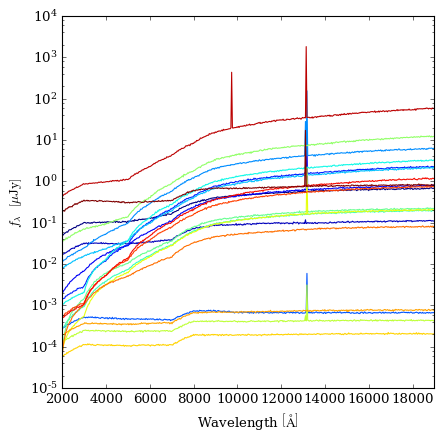

In [61]:
# Plot SEDs of first N galaxies
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
N = 20
carr = colour_array(N,cmap='jet')
for i in range(N):
    ax.plot(SED.wavelength,SED.sed[i,:],c=carr[i])
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(SED.wavelength.min(),SED.wavelength.max())
show()

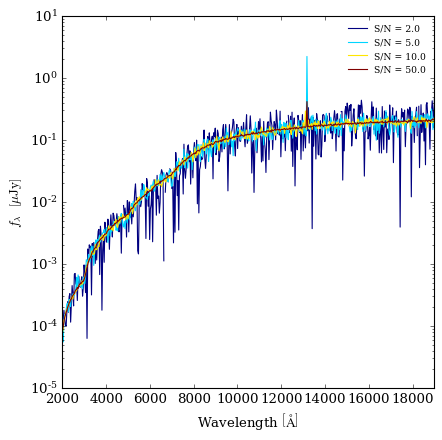

In [62]:
# EXAMPLE 2: Make plot showing different S/N ratios
z = 1.4
zStr = GH5.getRedshiftString(z)
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
snRatios = "2.0 5.0 10.0 50.0".split()
carr = colour_array(len(snRatios),cmap='jet')
for i,snr in enumerate(snRatios):        
    name = "totalSED:observed:Gaussian_VelocityApprox:snr"+snr+":"+zStr
    SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')
    ax.plot(SED.wavelength,SED.sed[12,:],c=carr[i],label="S/N = "+snr)
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(SED.wavelength.min(),SED.wavelength.max())
Legend(ax,loc=0)
show()
    

In [30]:
# Other galaxy properties can be extracted using the GalacticusHDF5 class. For example:
z = 1.47
properties = GH5.availableDatasets(z)
#print properties

In [31]:
# Let's, for example, extract the lightcone redshifts of the galaxies from the output nearest to snapshot redshift 1.47.
import fnmatch
# Print all lightcone properties
print fnmatch.filter(properties,"lightcone*")

[]


In [32]:
# The lightcone redshift is stored as 'lightconeRedshift'. Read lightcone redshifts into numyp array.
galaxies = GH5.readGalaxies(z,props=["lightconeRedshift"])
print galaxies["lightconeRedshift"]

TypeError: Empty data-type

In [ ]:
# EXAMPLE 3.1: Make plot showing SEDs for random sample of galaxies at different redshifts 
#              (using single snapshot directory)
z = 1.4
zStr = GH5.getRedshiftString(z)
redshifts = GH5.readGalaxies(z,props=["lightconeRedshift"])["lightconeRedshift"]
name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')

galaxyIndices = np.arange(len(redshifts))
np.random.shuffle(galaxyIndices)

halpha = GalSED.EmissionLines.EmissionLines.getWavelength("balmerAlpha6563")
##print halpha
#halpha = 6563.0

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')
N = 10
carr = colour_array(N,cmap='jet')
for i in range(N):
    z = redshifts[i]
    line, = ax.plot(SED.wavelength,SED.sed[i,:],c=carr[i],label="z = "+sigfig(z,4))
    ax.axvline(halpha*(1.0+z),c=line.get_color(),ls=':')
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(16000,16500)
minor_ticks(ax.xaxis)
Legend(ax,loc=0,title="H-alpha lines")
show()

In [ ]:
# EXAMPLE 3.2: Make plot showing SEDs for random sample of galaxies at different redshifts 
#              (using different snapshot directories)

halpha = GalSED.EmissionLines.EmissionLines.getWavelength("balmerAlpha6563")

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111,yscale='log')

redshifts = [1.4,1.6,1.8]
for z in redshifts:
    zStr = GH5.getRedshiftString(z)
    redshifts = GH5.readGalaxies(z,props=["lightconeRedshift"])["lightconeRedshift"]
    name = "totalSED:observed:Gaussian_VelocityApprox:snr5.0:"+zStr
    SED = GalSED.buildSED(name,wavelengths,kind='linear',fill_value='extrapolate')

    galaxyIndices = np.arange(len(redshifts))
    np.random.shuffle(galaxyIndices)    
    N = 2
    for i in range(N):
        iz = redshifts[i]
        line, = ax.plot(SED.wavelength,SED.sed[i,:],label="z = "+sigfig(iz,4))
        ax.axvline(halpha*(1.0+iz),c=line.get_color(),ls=':',lw=2.0)
ax.set_xlabel("Wavelength $\left[{\\rm \AA}\\right ]$")
ax.set_ylabel("$f_{\lambda}$  $\left [{\\rm \mu Jy}\\right ]$")
ax.set_xlim(16000,17000)
minor_ticks(ax.xaxis)
Legend(ax,loc=0,title="H-alpha lines")
show()

In [ ]:
# Now find the stellar masses.
print fnmatch.filter(properties,"*MassStellar")

In [ ]:
# Stellar masses for the disk and bulge are stored separately. If the stellar mass for the total galaxy has been
# calculated it we will see a dataset "totalMassStellar". It looks like that the total stellar mass has not yet
# been computed, so we will have the compute it using the separate components.
galaxies = GH5.readGalaxies(z,props=["*MassStellar"])
# We can use wildcards to extract multiple properties
print galaxies.dtype.names
stellarMass = galaxies["diskMassStellar"] + galaxies["spheroidMassStellar"]
print stellarMass
# Note that some 'galaxies' have zero stellar mass. These entries in fact correspond to empty dark matter halos and
# so could be masked out.
mask = stellarMass > 0.0